In [1]:
import os
from datetime import datetime
import re
import random
from collections import Counter, defaultdict

import pandas as pd
from matplotlib import pyplot as plt, font_manager, rcParams

# Set random seed
SEED = 42
random.seed(SEED)

# Plot font configuration
FONT_PATH = "./fonts/Noto_Sans_Javanese/static/NotoSansJavanese-Regular.ttf"
font_manager.fontManager.addfont(FONT_PATH)
rcParams["font.family"] = font_manager.FontProperties(fname=FONT_PATH).get_name()


In [2]:
TOTAL_SAMPLE = 1200
TOTAL_TRAIN = 1000
TOTAL_VAL = 200

CONFIG = {
    "min_word": 2,
    "max_word": 6,
}

BASE_DIR = f"./data/word_nglegena_synthetic_{datetime.now().strftime('%Y%m%d_%H%M%S')}"
os.makedirs(BASE_DIR, exist_ok=True)

NGLEGENA = [
    ("ꦲ","ha"), ("ꦤ","na"), ("ꦕ","ca"), ("ꦫ","ra"), ("ꦏ","ka"),
    ("ꦢ","da"), ("ꦠ","ta"), ("ꦱ","sa"), ("ꦮ","wa"), ("ꦭ","la"),
    ("ꦥ","pa"), ("ꦝ","dha"), ("ꦗ","ja"), ("ꦪ","ya"), ("ꦚ","nya"),
    ("ꦩ","ma"), ("ꦒ","ga"), ("ꦧ","ba"), ("ꦛ","tha"), ("ꦔ","nga"),
]


In [3]:
def generate_word(cfg):
    length = random.randint(cfg["min_word"], cfg["max_word"])
    jawa, latin = "", ""

    for _ in range(length):
        aks, lat = random.choice(NGLEGENA)
        jawa += aks
        latin += lat

    return jawa, latin, length


def generate_dataset(total, cfg, coverage):
    rows = []
    seen_words = set()
    idx = 0

    while len(rows) < total:
        jawa, latin, length = generate_word(cfg)

        if jawa in seen_words:
            continue
        seen_words.add(jawa)

        coverage["word"][length] += 1
        for aks in jawa:
            coverage["aksara"][aks] += 1

        rows.append({
            "image": f"s_img_{idx:05d}.png",
            "transcription": jawa,
            "transliteration": latin,
            "length": length,
        })
        idx += 1

    return pd.DataFrame(rows)



coverage = {
    "aksara": Counter({aks: 0 for aks, _ in NGLEGENA}),
    "word": Counter()
}
df = generate_dataset(TOTAL_SAMPLE, CONFIG, coverage)
print(f"Total generated samples: {len(df)}")



# Split train-val based on length distribution
groups = defaultdict(list)
for _, row in df.iterrows():
    groups[row["length"]].append(row)

train_rows = []
val_rows = []

for length, rows in groups.items():
    rows = rows.copy()
    random.shuffle(rows)

    n_total = len(rows)
    n_val = round(n_total * TOTAL_VAL / TOTAL_SAMPLE)
    n_train = n_total - n_val

    train_rows.extend(rows[:n_train])
    val_rows.extend(rows[n_train:])

assert len(train_rows) == TOTAL_TRAIN
assert len(val_rows) == TOTAL_VAL
random.shuffle(train_rows)
random.shuffle(val_rows)
df_train = pd.DataFrame(train_rows)
df_val = pd.DataFrame(val_rows)

train_csv = os.path.join(BASE_DIR, "label_train.csv")
val_csv = os.path.join(BASE_DIR, "label_val.csv")
df_train.to_csv(train_csv, index=False)
df_val.to_csv(val_csv, index=False)
print(f"Saved {len(df_train)} samples to {train_csv}")
print(f"Saved {len(df_val)} samples to {val_csv}")


Total generated samples: 1200
Saved 1000 samples to ./data/word_nglegena_synthetic_20260109_223615\label_train.csv
Saved 200 samples to ./data/word_nglegena_synthetic_20260109_223615\label_val.csv


In [4]:
ALLOWED_CHARS = set([aks for aks, _ in NGLEGENA])
REQUIRED_COLS = {"image", "transcription", "transliteration", "length"}
ROWS_PER_CSV = 50


def validate_csv(csv_path):
    print(f"\nValidating file: {csv_path}")
    print("-" * 50)

    df = pd.read_csv(csv_path)

    print(f"Jumlah baris               : {len(df)}")
    if len(df) != ROWS_PER_CSV:
        print("Jumlah baris tidak sesuai")

    missing_cols = REQUIRED_COLS - set(df.columns)
    if missing_cols:
        print(f"Kolom wajib hilang       : {missing_cols}")
    else:
        print("Skema kolom              : valid")

    null_rows = df[df.isnull().any(axis=1)]
    print(f"Baris dengan nilai kosong  : {len(null_rows)}")

    dup_pair = df[df.duplicated(["image", "transcription"], keep="first")]
    dup_semantic = df[df.duplicated(["transcription", "transliteration"], keep="first")]

    print(f"Duplikat image–label       : {len(dup_pair)}")
    print(f"Duplikat semantic label    : {len(dup_semantic)}")

    length_mismatch = df[df["transcription"].str.len() != df["length"]]
    print(f"Length mismatch            : {len(length_mismatch)}")

    oov_counter = Counter()
    oov_rows = []

    for idx, text in df["transcription"].items():
        oov = [ch for ch in text if ch not in ALLOWED_CHARS]
        if oov:
            oov_rows.append(idx)
            oov_counter.update(oov)

    print(f"Baris mengandung OOV       : {len(oov_rows)}")
    if oov_counter:
        print("OOV aksara:")
        for ch, c in oov_counter.items():
            print(f"  '{ch}' : {c}x")

    ctrl_rows = df[df["transcription"].apply(
        lambda x: bool(re.search(r"[\u0000-\u001F\u007F]", x))
    )]
    print(f"Karakter kontrol tersembunyi : {len(ctrl_rows)}")

    problem_idx = set()
    problem_idx.update(null_rows.index)
    problem_idx.update(dup_pair.index)
    problem_idx.update(dup_semantic.index)
    problem_idx.update(length_mismatch.index)
    problem_idx.update(oov_rows)
    problem_idx.update(ctrl_rows.index)

    print(f"Total baris bermasalah     : {len(problem_idx)}")
    print(f"Total baris valid          : {len(df) - len(problem_idx)}")



train_csv = os.path.join(BASE_DIR, "label_train.csv")
val_csv = os.path.join(BASE_DIR, "label_val.csv")
validate_csv(train_csv)
validate_csv(val_csv)


Validating file: ./data/word_nglegena_synthetic_20260109_223615\label_train.csv
--------------------------------------------------
Jumlah baris               : 1000
Jumlah baris tidak sesuai
Skema kolom              : valid
Baris dengan nilai kosong  : 0
Duplikat image–label       : 0
Duplikat semantic label    : 0
Length mismatch            : 0
Baris mengandung OOV       : 0
Karakter kontrol tersembunyi : 0
Total baris bermasalah     : 0
Total baris valid          : 1000

Validating file: ./data/word_nglegena_synthetic_20260109_223615\label_val.csv
--------------------------------------------------
Jumlah baris               : 200
Jumlah baris tidak sesuai
Skema kolom              : valid
Baris dengan nilai kosong  : 0
Duplikat image–label       : 0
Duplikat semantic label    : 0
Length mismatch            : 0
Baris mengandung OOV       : 0
Karakter kontrol tersembunyi : 0
Total baris bermasalah     : 0
Total baris valid          : 200


RINGKASAN DATA : ./data/word_nglegena_synthetic_20260109_223615\label_train.csv
Total kata            : 1000
Min panjang kata      : 2
Max panjang kata      : 6
Rata-rata panjang     : 4.12

DISTRIBUSI PANJANG KATA
 2 aksara |   147 baris |  14.70%
 3 aksara |   216 baris |  21.60%
 4 aksara |   223 baris |  22.30%
 5 aksara |   198 baris |  19.80%
 6 aksara |   216 baris |  21.60%


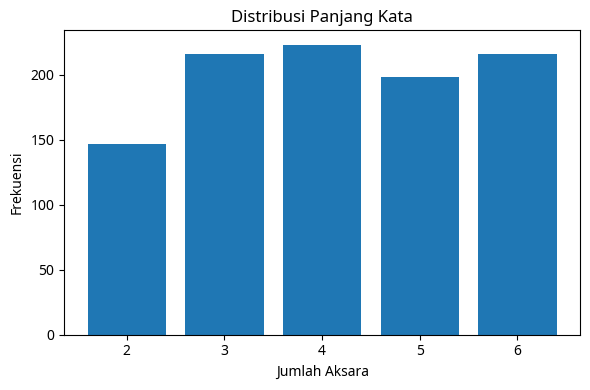

DISTRIBUSI AKSARA
  ꦲ (ha ) |    174 |   4.22%
  ꦤ (na ) |    200 |   4.85%
  ꦕ (ca ) |    214 |   5.19%
  ꦫ (ra ) |    204 |   4.95%
  ꦏ (ka ) |    208 |   5.05%
  ꦢ (da ) |    196 |   4.76%
  ꦠ (ta ) |    183 |   4.44%
  ꦱ (sa ) |    202 |   4.90%
  ꦮ (wa ) |    207 |   5.02%
  ꦭ (la ) |    203 |   4.93%
  ꦥ (pa ) |    210 |   5.10%
  ꦝ (dha) |    197 |   4.78%
  ꦗ (ja ) |    218 |   5.29%
  ꦪ (ya ) |    202 |   4.90%
  ꦚ (nya) |    217 |   5.27%
  ꦩ (ma ) |    218 |   5.29%
  ꦒ (ga ) |    201 |   4.88%
  ꦧ (ba ) |    252 |   6.12%
  ꦛ (tha) |    206 |   5.00%
  ꦔ (nga) |    208 |   5.05%

Total aksara: 4120


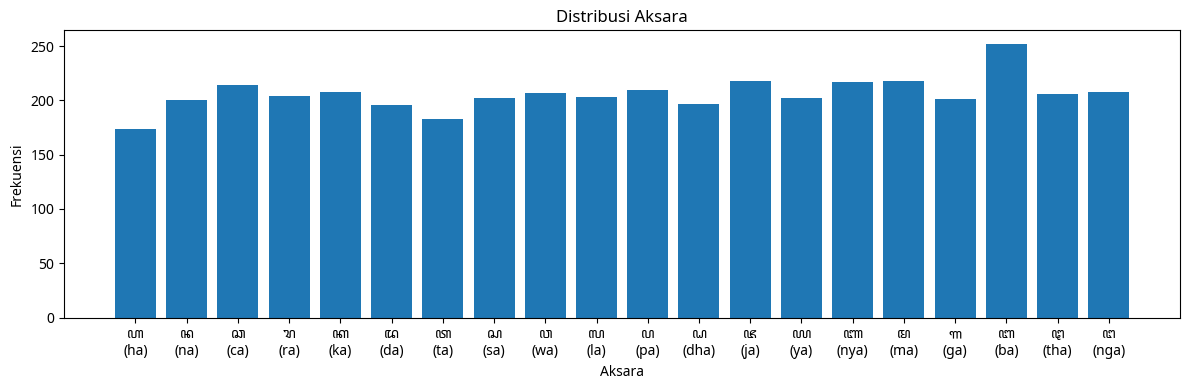

RINGKASAN DATA : ./data/word_nglegena_synthetic_20260109_223615\label_val.csv
Total kata            : 200
Min panjang kata      : 2
Max panjang kata      : 6
Rata-rata panjang     : 4.12

DISTRIBUSI PANJANG KATA
 2 aksara |    29 baris |  14.50%
 3 aksara |    43 baris |  21.50%
 4 aksara |    45 baris |  22.50%
 5 aksara |    40 baris |  20.00%
 6 aksara |    43 baris |  21.50%


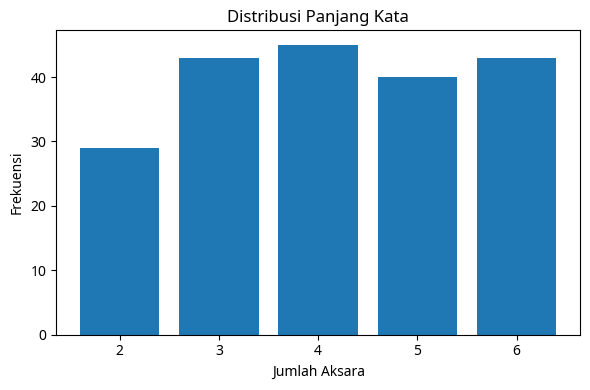

DISTRIBUSI AKSARA
  ꦲ (ha ) |     34 |   4.12%
  ꦤ (na ) |     45 |   5.45%
  ꦕ (ca ) |     41 |   4.97%
  ꦫ (ra ) |     41 |   4.97%
  ꦏ (ka ) |     48 |   5.82%
  ꦢ (da ) |     45 |   5.45%
  ꦠ (ta ) |     46 |   5.58%
  ꦱ (sa ) |     40 |   4.85%
  ꦮ (wa ) |     46 |   5.58%
  ꦭ (la ) |     43 |   5.21%
  ꦥ (pa ) |     46 |   5.58%
  ꦝ (dha) |     36 |   4.36%
  ꦗ (ja ) |     37 |   4.48%
  ꦪ (ya ) |     39 |   4.73%
  ꦚ (nya) |     48 |   5.82%
  ꦩ (ma ) |     37 |   4.48%
  ꦒ (ga ) |     40 |   4.85%
  ꦧ (ba ) |     23 |   2.79%
  ꦛ (tha) |     39 |   4.73%
  ꦔ (nga) |     51 |   6.18%

Total aksara: 825


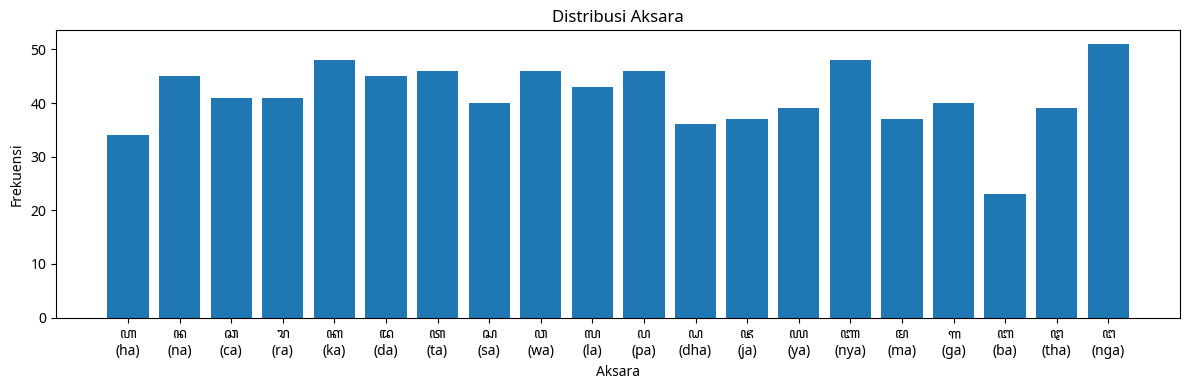

In [5]:
def plot_bar(x, y, title, xlabel, ylabel, figsize):
    plt.figure(figsize=figsize)
    plt.bar(x, y)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.tight_layout()
    plt.show()


def analyze_csv(
    csv_path,
    nglegena,
    show_plot=True,
):
    df = pd.read_csv(csv_path)
    latin_map = {aks: lat for aks, lat in nglegena}

    # ==============================
    # DATA SUMMARY
    # ==============================
    print("=" * 40)
    print(f"RINGKASAN DATA : {csv_path}")
    print("=" * 40)

    print(
        f"Total kata            : {len(df)}\n"
        f"Min panjang kata      : {df['length'].min()}\n"
        f"Max panjang kata      : {df['length'].max()}\n"
        f"Rata-rata panjang     : {df['length'].mean():.2f}\n"
    )

    # ==============================
    # WORD LENGTH DISTRIBUTION
    # ==============================
    print("=" * 40)
    print("DISTRIBUSI PANJANG KATA")
    print("=" * 40)

    length_dist = df["length"].value_counts().sort_index()
    total_words = len(df)

    for length, count in length_dist.items():
        pct = count / total_words * 100
        print(f"{length:>2} aksara | {count:5d} baris | {pct:6.2f}%")

    if show_plot:
        plot_bar(
            length_dist.index,
            length_dist.values,
            "Distribusi Panjang Kata",
            "Jumlah Aksara",
            "Frekuensi",
            (6, 4),
        )

    # ==============================
    # AKSARA DISTRIBUTION
    # ==============================
    print("=" * 40)
    print("DISTRIBUSI AKSARA")
    print("=" * 40)

    aksara_counter = Counter()
    for text in df["transcription"]:
        aksara_counter.update(text)

    aksara_dist = pd.DataFrame(
        [(aks, aksara_counter.get(aks, 0)) for aks, _ in nglegena],
        columns=["aksara", "count"],
    )
    aksara_dist["latin"] = aksara_dist["aksara"].map(latin_map)

    total_aksara = aksara_dist["count"].sum()

    for _, row in aksara_dist.iterrows():
        pct = (row["count"] / total_aksara * 100) if total_aksara else 0
        print(
            f"{row['aksara']:>3} ({row['latin']:<3}) | "
            f"{row['count']:6d} | {pct:6.2f}%"
        )

    print(f"\nTotal aksara: {total_aksara}")

    if show_plot:
        plot_bar(
            [f"{a}\n({latin_map[a]})" for a in aksara_dist["aksara"]],
            aksara_dist["count"],
            "Distribusi Aksara",
            "Aksara",
            "Frekuensi",
            (12, 4),
        )



train_csv = os.path.join(BASE_DIR, "label_train.csv")
val_csv = os.path.join(BASE_DIR, "label_val.csv")
analyze_csv(train_csv, NGLEGENA)
analyze_csv(val_csv, NGLEGENA)